# Model Description

Gradient boosting is an ensemble training method that can be trained using gradient descent. It often uses decision trees as the weak learners in its ensemble. 

**Note: The explorotary data analysis component of this notebook is identical to the logistic regression notebook.**

# Exploratory Data Analysis

> "To predict data, we must first understand data"
>
> — Yoda, or someone, probably

What do our (possible) features mean, (neglecting obvious ones): 
- _RevolvingUtilizationOfUnsecuredLines_ : Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits
- _NumberOfTime30-59DaysPastDueNotWorse_ :  Number of times borrower has been 30-59 days past due but no worse in the last 2 years.
- _NumberRealEstateLoansOrLines_ : Number of mortgage and real estate loans including home equity lines of credit
- _NumberOfOpenCreditLinesAndLoans_ : Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards)
- _DebtRatio_ : Monthly debt payments, alimony, living costs divided by monthy gross income

We will clean up our data and replace or identify any NaNs. We will then understand the variance and skews of all of our input features. Finally we will consider the collinearity of our features, that is: the degree to which input features are correlated to each other, and therefore "redundant".

In [1]:
#Import statements
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
pd.options.display.max_rows = 20
from sklearn.model_selection import train_test_split
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor
import xgboost as xgb

#Import raw data
data_raw = pd.read_csv("./Datasets/Kaggle - Give Me Some Credit/cs-training.csv")
output_raw = pd.read_csv("./Datasets/Kaggle - Give Me Some Credit/cs-test.csv")
data_clean = data_raw.copy()
output_clean = output_raw.copy()
# Set seed so train/test split remains consistent over runs
seed = 42

## Data Cleaning

*Good hygiene  is essential when handling raw data.*

In [2]:
data_raw.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


We impute in our NaNs with the datasets means. We can also later try removing them entirely to see if the BIC/AIC of the model improves (decreases). 

In [3]:
# Find out how many NaNs we're dealing with here. 
print(data_raw.isnull().sum())

# Fill NaNs with mean.
data_clean['MonthlyIncome'].fillna(data_clean['MonthlyIncome'].mean(),inplace=True)
data_clean['NumberOfDependents'].fillna(data_clean['NumberOfDependents'].mean(),inplace=True)
#Number of delinquents vs non
print((data_clean['SeriousDlqin2yrs'] == 0).value_counts())

# Split data to train and test
train, test = train_test_split(data_clean,test_size=0.3,random_state=seed)
X = train.iloc[:,2:]
Y = train.iloc[:,1]
X_test = test.iloc[:,2:]
Y_test = test.iloc[:,1]

Unnamed: 0                                  0
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64
True     139974
False     10026
Name: SeriousDlqin2yrs, dtype: int64


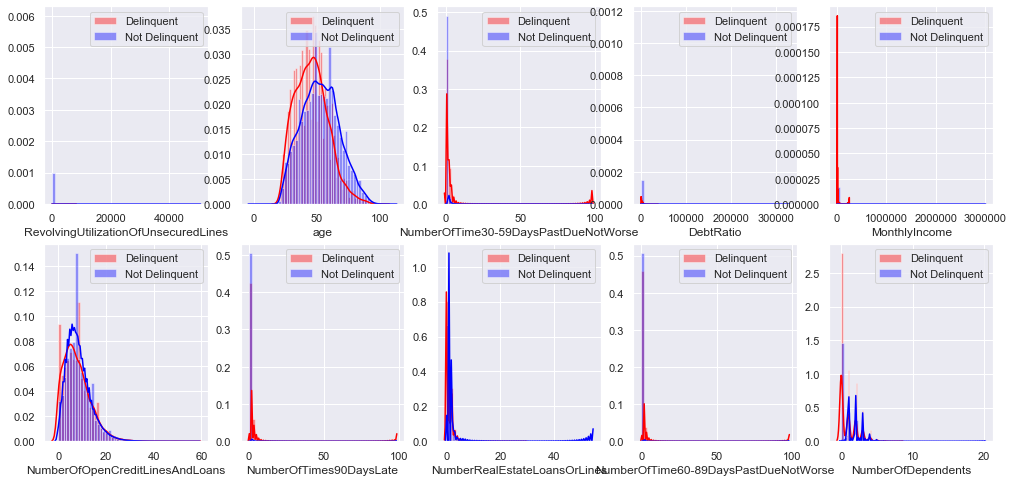

In [4]:
f, axes = plt.subplots(2, 5, figsize=(17, 8))
data_describe = data_clean.describe()
for index,ax in enumerate(axes.reshape(-1)):
    delinquent = data_clean['SeriousDlqin2yrs'] == 1
    sns.distplot(data_clean.loc[delinquent].iloc[:,index+2],ax=ax,color="red",label="Delinquent")
    sns.distplot(data_clean.loc[~delinquent].iloc[:,index+2],ax=ax,color="blue",label="Not Delinquent")
    ax.legend()

In [5]:
# Get skews
print("Skew values: ")
skews = data_clean.iloc[:,2:].skew(axis=0)
print(skews)

Skew values: 
RevolvingUtilizationOfUnsecuredLines     97.631574
age                                       0.188995
NumberOfTime30-59DaysPastDueNotWorse     22.597108
DebtRatio                                95.157793
MonthlyIncome                           127.357969
NumberOfOpenCreditLinesAndLoans           1.215314
NumberOfTimes90DaysLate                  23.087345
NumberRealEstateLoansOrLines              3.482484
NumberOfTime60-89DaysPastDueNotWorse     23.331743
NumberOfDependents                        1.609433
dtype: float64


### Notes

We can see a couple of things here. 

The first is the severity of the skew in a number of our dependent variables. We will address this properly in our later models down below. 

The second is that a number of the dependents show a difference in distribution, so there is necessarily some discriminatory information present within these variables. (Age for e.g)

## Check collinearity

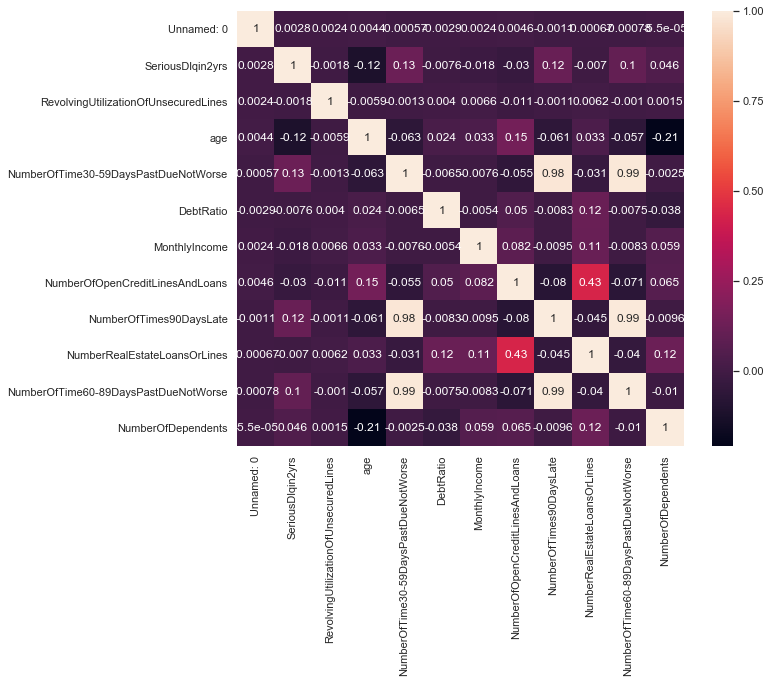

In [10]:
# Check collinearity
corr = data_clean.corr()
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(corr,annot=True,ax=ax)

### Note: 

As expected, the features relating to deliquencies in various time bins are highly correlated with each other. We also have correlation between the two open credit line variables, also expected since NumberOfOpenCreditLinesAndLoans is inclusive of all loans, including mortgage or real estate loans. 

Collinearity tends to cause overinflation of the variance (standard error) of our regression coefficients. To check that collinearity is an actual problem we will need to calculate the VIF (variance inflation factor) which quantifies just how large this standard error is. A VIF of > 10 is a sign that multicollinearity is high. We will check on this later once we develop our models. Unfortunately VIF for logistic regression isn't particularly well-defined as it is designed for OLS with the R^2 metric. Hypothetically you could use Pseudo-R^2 but as I am using this simply as a diagnostic tool I will use standard OLS based VIF. 

In [6]:
def getVIFs(design_matrix):
    output = pd.DataFrame(0,columns=['VIFs'],index=design_matrix.columns)
    for index,column in enumerate(design_matrix.columns): 
        output['VIFs'][column] = variance_inflation_factor(design_matrix.to_numpy(),index)
    return output


getVIFs(X_test)

,VIFs
RevolvingUtilizationOfUnsecuredLines,1
age,3
NumberOfTime30-59DaysPastDueNotWorse,36
DebtRatio,1
MonthlyIncome,1
NumberOfOpenCreditLinesAndLoans,4
NumberOfTimes90DaysLate,66
NumberRealEstateLoansOrLines,2
NumberOfTime60-89DaysPastDueNotWorse,81
NumberOfDependents,1


# Gradient Boost Model - Initial Attempt

We use all the available features for our input feature vector and train a regression model on the P(SeriousDlqin2Yrs)


In [7]:
X_2 = X.copy()
X_test_2 = X_test.copy()

X_2.loc[:,skews.values>2] = np.log(X_2.loc[:,skews.values>2] + 0.00001)
X_test_2.loc[:,skews.values>2] = np.log(X_test_2.loc[:,skews.values>2] + 0.00001)

In [8]:
model2 = xgb.XGBClassifier(objective="binary:logistic",random_state=seed).fit(X_2,Y)

In [11]:
def print_metrics(realX,realY,model):
    predicted = model.predict(realX)
    predicted_prob = model.predict_proba(realX)[:,1]
    confusion_matrix = model.score
    fpr, tpr, _ = metrics.roc_curve(realY,predicted_prob)
    auc = metrics.roc_auc_score(realY,predicted_prob)
    f1score = metrics.f1_score(realY,predicted)
    pscore = metrics.precision_score(realY,predicted)
    rscore = metrics.recall_score(realY,predicted)
    print("The AUC is: ", auc)
    print("The F1 score is: ",f1score)
    print("The precision score is: ", pscore)
    print("The recall score is: ", rscore)
    plt.plot(fpr,tpr)
    

The AUC is:  0.8648376492178541
The F1 score is:  0.29239766081871343
The precision score is:  0.6033578174186779
The recall score is:  0.1929530201342282


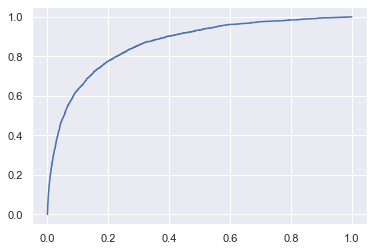

In [12]:
print_metrics(X_test_2,Y_test,model2)